# Model: Trackster neighborhood approach

Input:
- graph of tracksters in the cone neighbourhood.
- list of edges
- label 1 or 0 for each edge

Options:
- use EdgeConv operators to extract information from the neighborhood
    - then predict binary output per edge
- try: use DGCNN to let the network make its own edges in the latent space
    - force the original edges in the last conv layer to get the same output?

Use the batch trick to encode multiple samples at once (need to reindex edges).
- start with batch size 1 to make this easier

Using torch_geometric here as it's much easier.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import random_split
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.nn import EdgeConv, DynamicEdgeConv
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
import torch_geometric.utils as geo_utils

import sklearn.metrics as metrics

from reco.learn import train_edge_pred, test_edge_pred
from reco.dataset import TracksterGraph
from reco.loss import FocalLoss

ds_name = "CloseByTwoPion"

# data_root = "data"
# raw_dir = f"/Users/ecuba/data/{ds_name}"

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [12]:
transform = T.Compose([T.NormalizeFeatures()])

ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=100,
    MAX_DISTANCE=10,
    ENERGY_THRESHOLD=10,
    include_graph_features=False,
    transform=transform,
)
ds

TrackstersGraph(graphs=9989, nodes=281250, edges=1015571, max_distance=10, energy_threshold=10, graph_features=False)

In [13]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}")

# this is very nice - handles the dimensions automatically
train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train graphs: 8991, Test graphs: 998


In [14]:
print(f"dataset balance: {float(sum(ds.data.y) / len(ds.data.y)):.3f}") 

dataset balance: 0.301


In [15]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# ParticleNet

class EdgeConvBlock(nn.Module):

    def __init__(self, input_dim, hidden_dim, aggr="add", skip_link=False, k=8):
        super(EdgeConvBlock, self).__init__()

        convnetwork = nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        self.graphconv = EdgeConv(nn=convnetwork, aggr=aggr)
        self.dynamicgraphconv = DynamicEdgeConv(nn=convnetwork, aggr=aggr, k=k)
        self.skip_link = skip_link
        
    def forward(self, X, edge_index=None):
        
        if edge_index is None:
            H = self.dynamicgraphconv(X)
        else:
            H = self.graphconv(X, edge_index)

        if self.skip_link:
            return torch.hstack((H, X))

        return H    



class GraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, aggr='add', dropout=0.2, skip_link=False):
        """
        skip_link might not make so much difference if the edges are fixed
        """
        
        super(GraphNet, self).__init__()

        hdim1 = 64
        in_dim2 = hdim1 + input_dim if skip_link else hdim1
        
        hdim2 = 128
        in_dim3 = hdim2 + in_dim2 if skip_link else hdim2

        hdim3 = 256
        in_dim4 = hdim3 + in_dim3 if skip_link else hdim3

        # EdgeConv
        self.graphconv1 = EdgeConvBlock(input_dim, hdim1, skip_link=skip_link)
        self.graphconv2 = EdgeConvBlock(in_dim2, hdim2, skip_link=skip_link)
        self.graphconv3 = EdgeConvBlock(in_dim3, hdim3, skip_link=skip_link)

        # Edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * in_dim4, hdim3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim3, output_dim),
            nn.Sigmoid()
        )
            
    def forward(self, X, edge_index):        
        # (prepared_edges, _) = geo_utils.add_self_loops(edge_index)  
        undirected_index = geo_utils.to_undirected(edge_index)

        H = self.graphconv1(X, undirected_index)
        H = self.graphconv2(H)
        H = self.graphconv3(H)
        
        src, dst = edge_index
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [21]:
model = GraphNet(input_dim=ds.data.x.shape[1], skip_link=True)
epochs = 50

# loss_func = F.binary_cross_entropy_with_logits
# alpha - percentage of negative edges
loss_func = FocalLoss(alpha=0.3, gamma=2)

model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)

for epoch in range(epochs):

    train_loss, train_true, train_pred = train_edge_pred(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    train_acc = metrics.accuracy_score(train_true, (train_pred > 0.5).astype(int))
    scheduler.step()

    if epoch % 2 == 0:
        test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl)
        test_acc = metrics.accuracy_score(test_true, (test_pred > 0.5).astype(int))
        print(
            f"Epoch {epoch}:",
            f"\ttrain loss:{train_loss:.2f}\ttrain acc: {train_acc:.3f}",
            f"\t test loss:{test_loss:.2f} \t test acc: {test_acc:.3f}"
        )

Epoch 0: 	train loss:510.86	train acc: 0.772 	 test loss:36.15 	 test acc: 0.803
Epoch 2: 	train loss:276.87	train acc: 0.821 	 test loss:24.73 	 test acc: 0.835
Epoch 4: 	train loss:201.62	train acc: 0.841 	 test loss:18.62 	 test acc: 0.851
Epoch 6: 	train loss:153.76	train acc: 0.856 	 test loss:14.56 	 test acc: 0.864
Epoch 8: 	train loss:123.59	train acc: 0.868 	 test loss:11.51 	 test acc: 0.876
Epoch 10: 	train loss:103.90	train acc: 0.876 	 test loss:9.80 	 test acc: 0.884
Epoch 12: 	train loss:88.78	train acc: 0.884 	 test loss:8.39 	 test acc: 0.891
Epoch 14: 	train loss:78.63	train acc: 0.889 	 test loss:7.64 	 test acc: 0.895
Epoch 16: 	train loss:70.53	train acc: 0.894 	 test loss:6.77 	 test acc: 0.900
Epoch 18: 	train loss:65.31	train acc: 0.897 	 test loss:6.49 	 test acc: 0.901
Epoch 20: 	train loss:60.26	train acc: 0.900 	 test loss:5.72 	 test acc: 0.905
Epoch 22: 	train loss:56.31	train acc: 0.903 	 test loss:5.52 	 test acc: 0.907
Epoch 24: 	train loss:52.89	train 

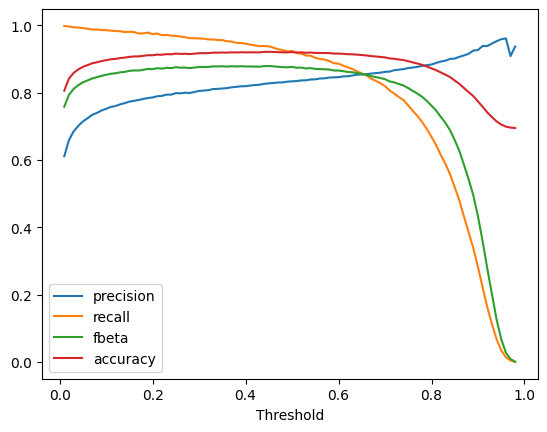

Th: 0.45 | F-score: 0.880 | accuracy: 0.922


In [22]:
th_values = [i / 100. for i in range(1, 99)]
precision = []
recall = []
fbeta = []
accuracy = []

for th in th_values:
    test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl)

    pred = (test_pred > th).astype(int)

    if sum(pred) == 0:
        precision.append(0)
        recall.append(0)
        fbeta.append(0)
        accuracy.append(0)
    else:
        accuracy.append(metrics.accuracy_score(test_true, pred))
        precision.append(metrics.precision_score(test_true, pred))
        recall.append(metrics.recall_score(test_true, pred))
        fbeta.append(metrics.fbeta_score(test_true, pred, beta=1))

plt.figure()
plt.plot(th_values, precision, label="precision")
plt.plot(th_values, recall, label="recall")
plt.plot(th_values, fbeta, label="fbeta")
plt.plot(th_values, accuracy, label="accuracy")
plt.xlabel("Threshold")
plt.legend()
plt.show()

decision_th = th_values[np.argmax(fbeta)]
print(f"Th: {decision_th} | F-score: {max(fbeta):.3f} | accuracy: {accuracy[np.argmax(fbeta)]:.3f}")

In [23]:
torch.save(model.state_dict(), f"models/DynamicParticleNet_64_128_256_skip-{epochs}e-CloseByTwoPion_10_10_ngf_{ds.N_FILES}f.pt")

## Scoreboard
- ParticleNet_64_128_256_skip
    - Best F-score: 0.902
    - Accuracy: 0.937
    
 - ParticleNet_64_128_256_noskip
     - Best F-score: 0.902
     - accuracy: 0.937
     
     
 - DynamicParticleNet_64_128_256_skip (this thing is super slow)
     - F-score: 0.880
     - accuracy: 0.922




# Evaluation

In [ ]:
import uproot
import numpy as np
from reco.evaluation import graph_model_evaluation

file_name = f"{raw_dir}/new_ntuples_15101852_455.root"
tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [ ]:
result = graph_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    graphs,
    model.to("cpu"),
    decision_th,
    max_distance=10,
    energy_threshold=10,
    max_events=10,
)